Debugging links (converting images to JPG and stripping alpha-channels):

- [Use Pillow to convert image to .jpg](https://stackoverflow.com/questions/43258461/convert-png-to-jpeg-using-pillow-in-python)
- [Pytorch forums: Handling images with transparencies](https://discuss.pytorch.org/t/handling-images-with-transparencies/7045)
- [Use PIL to convert RGBA or PNG to RGB](https://stackoverflow.com/a/9459208)
 - [Converting Palette-Based PNG w transparency to RGB in PIL](https://stackoverflow.com/questions/32730687/how-do-i-convert-palette-based-png-with-transparency-to-rgb-in-pil) (links to above link)

In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [47]:
from fastai import *
from fastai.vision import *

In [61]:
bs = 64; size = 224

In [62]:
path = Path().home()/'data/aircraft'

In [65]:
data = ImageDataBunch.from_folder(path, train="temp", valid_pct=0.2,
                                  df_tfms=get_transforms(), bs=bs, size=size)

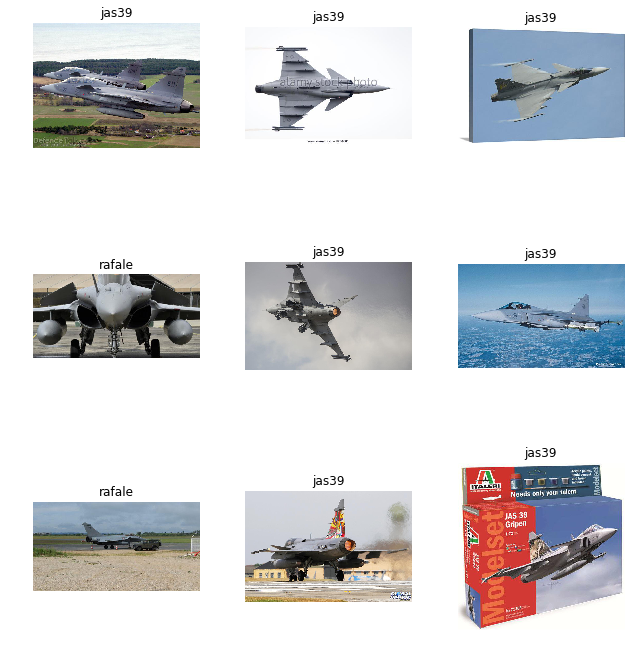

In [66]:
data.show_batch(rows=3, )

In [67]:
print(data.classes)
len(data.classes), data.c

['jas39', 'rafale']


(2, 2)

## Training: resnset34

In [68]:
print('\n',data.train_ds,'\n',data.valid_ds)


 ImageClassificationDataset of len 558 
 ImageClassificationDataset of len 146


In [69]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [70]:
next(iter(learn.data.train_dl))[0].size()

RuntimeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/jupyter/fastai/fastai/torch_core.py", line 91, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 317 and 438 in dimension 2 at /opt/conda/conda-bld/pytorch-nightly_1540411964561/work/aten/src/TH/generic/THTensorMoreMath.cpp:1317


In [28]:
learn.data.train_dl.one_batch()

[tensor([[[[0.5176, 0.5176, 0.5216,  ..., 0.6118, 0.6118, 0.6118],
           [0.5176, 0.5176, 0.5216,  ..., 0.6118, 0.6118, 0.6118],
           [0.5176, 0.5176, 0.5216,  ..., 0.6157, 0.6118, 0.6118],
           ...,
           [0.4941, 0.4863, 0.4784,  ..., 0.6706, 0.6706, 0.6706],
           [0.4824, 0.4784, 0.4706,  ..., 0.6667, 0.6667, 0.6667],
           [0.4863, 0.4824, 0.4745,  ..., 0.6667, 0.6667, 0.6667]],
 
          [[0.4863, 0.4863, 0.4902,  ..., 0.5725, 0.5725, 0.5725],
           [0.4863, 0.4863, 0.4902,  ..., 0.5725, 0.5725, 0.5725],
           [0.4863, 0.4863, 0.4902,  ..., 0.5765, 0.5725, 0.5725],
           ...,
           [0.4392, 0.4314, 0.4235,  ..., 0.6078, 0.6078, 0.6078],
           [0.4275, 0.4235, 0.4157,  ..., 0.6039, 0.6039, 0.6039],
           [0.4314, 0.4275, 0.4196,  ..., 0.6039, 0.6039, 0.6039]],
 
          [[0.4431, 0.4431, 0.4471,  ..., 0.5333, 0.5333, 0.5333],
           [0.4431, 0.4431, 0.4471,  ..., 0.5333, 0.5333, 0.5333],
           [0.4431, 0.44

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate


/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


RuntimeError: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/jupyter/fastai/fastai/torch_core.py", line 91, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 682 and 616 in dimension 2 at /opt/conda/conda-bld/pytorch-nightly_1540411964561/work/aten/src/TH/generic/THTensorMoreMath.cpp:1317


Exploring the issue more and running the lesson1-pets-copy notebook, the issue is that the images are **note** being resized by the dataloader, but they are being correctly resized in the fastai course notebook...

So I need to find out why. I think I read a bit of a pytorch forums thread that said something about the file format affecting whether or not pytorch can open and resize a file properly... or something, I don't know.

So my thought now is to simply 'convert' every single image in the dataset to JPEG and see what happens. If all images are in the 'correct' format and things still break... I have no clue.

It didn't work. I'm going to restart this entire project with a smaller sample dataset, maybe 20 images per category, and see what's going wrong.

In [60]:
from PIL import Image as pilimage

for c in (path/'temp').ls():
    for f in c.ls():
        im = pilimage.open(f)
        rgb_im = im.convert('RGB')
        rgb_im.save(f)

In [28]:
fs = (path/'train'/'mig21').ls()

In [109]:
fi = 190

In [182]:
# # can't find the problem image. going to kill everything in the range.
# remalpha = []
# for i in range(len(fs)):
#     if i > 190 and i < 200:
#         remalpha.append(fs[i])

200 / 382
265. mmm-25.png


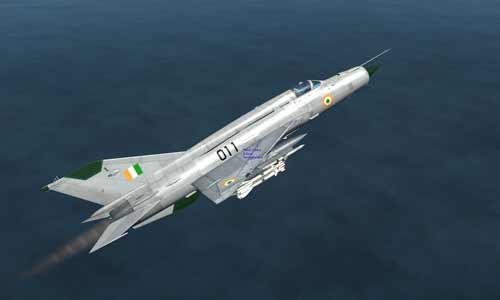

In [120]:
f = fs[fi]
print(f"{fi} / {len(fs)-1}")
print(f.name)
fi += 1
open_image(f)

In [17]:
remove_alphas = [
    'f14/302. kisspng-fighter-aircraft-grumman-f-14-tomcat-airplane-lock-six-5ac6f47fdfbef0.7271332215229881599165.jpg',
    'f22/499. kisspng-lockheed-martin-f-22-raptor-lockheed-martin-f-35-l-f-vector-5ad83d90d81de3.4950145115241209768853.jpg',
    'f22/439. kisspng-lockheed-martin-f-22-raptor-airplane-fighter-aircr-jet-5ac36b0ccef916.0147136315227563648478.jpg',
#     'f22/228. f226191.jpg',
    'f22/313. f22_fighter_jet_r.png',
    'mig21/47. 514pjidzpjl._sx679_.jpg',
    'mig21/251. 1-13112g53smv.jpg',
    'mig21/51. 9743176_freewing-mig-21-80mm-e-impeller-jet-6s-edf_570x570.jpg',
    'mig21/294. large.jpg',
    'mig21/71. 079b9327-a314-4130-a2c6-69e7296d542d_1.b9a96edd36a363b5b0373d58fd425e54.jpeg',
    'mig21/413. 26296835731_0172fcb679_z.jpg',
    'mig21/173. kisspng-fighter-aircraft-mikoyan-gurevich-mig-21-airplane-mig-21-5b0c19d84162f1.2771585415275197042678.jpg',
    'mig21/435. mig21mf_3v.jpg',
    'mig21/75. schematics.jpg',
    'mig21/111. mig-21-on-the-airfield.jpg',
    'mig21/429. yxvdwr99vgb72qhd_mig_21_bison_indian_air_force_iaf_000.jpg',
    'mig21/354. kisspng-airplane-fighter-aircraft-mikoyan-gurevich-mig-21-mig-21-5b0c1a6873a239.8596800715275198484737.jpg',
    'mig21/265. mmm-25.png'
]

In [127]:
# just kill ALL png images:
for c in data.classes:
    for imgf in (path/'train'/c).ls():
        if imgf.suffix=='.png':
#             print(c,imgf.name)
            remove_alphas.append(imgf)

In [18]:
# kill any image that's NOT strictly a jpg or jpeg:
for c in data.classes:
    for imgf in (path/'train'/c).ls():
        if imgf.suffix not in ['.jpg','.jpeg']:
#             print(c,imgf.name)
            remove_alphas.append(imgf)

In [130]:
# 252 png images to remove...
len(remove_alphas)

232

In [65]:
# (path/'train/mig21').ls()

In [19]:
for remalpha in remove_alphas:
    fpath = path/'train'/remalpha
#     print(fpath)
    try: os.remove(path/'train'/remalpha)
    except FileNotFoundError: pass

In [20]:
data = ImageDataBunch.from_folder(path, train="train", valid_pct=0.2,
                                  df_tfms=get_transforms(), bs=bs, size=size)

'su57'

In [31]:
img = pilimage.open(path/'train/rafale/48. 243120964-e1539792550961.jpg')

In [34]:
np.asarray(img).shape

(675, 1011, 3)

In [65]:
# what if I convert all images to JPG or something?

# yeah so there are 50 images across the dataset that have 4 channels.
# that will break things. So I'm going to convert them all to 3
# channel RGB.

from PIL import Image as pilimage

mb = master_bar(range(len((path/'train').ls())))
for ci in mb:
    c = (path/'train').ls()[ci]
    count = 0
    for fi in progress_bar(range(len(c.ls())), parent=mb):
        mb.child.comment = f'{c.name+":":<8}{count}'
        f = c.ls()[fi]
        png = pilimage.open(f)
        png.load() # required for png.split()

        background = pilimage.new("RGB", png.size, (255, 255, 255))
        try: 
            background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
            background.save(f, 'JPEG', quality=100)
#             print(c, f)
#             print(np.array(png).shape)
#             if np.array(png).shape[2] != 4:
#                 raise error
            count += 1
        except IndexError: pass
#             print(c, f)
#             print(np.array(png).shape)
    mb.write(f'{c.name} {count}',table=False)
print(count)
            


Total time: 00:50
rafale 0  (00:02)
f15c 6    (00:03)
mig21 0   (00:02)
f16 2     (00:02)
su27 2    (00:02)
f15e 8    (00:02)
jas39 5   (00:03)
f35 3     (00:02)
su24 1    (00:02)
su34 9    (00:03)
fa18ef 0  (00:01)
su25 2    (00:02)
mig29 1   (00:02)
fa18c 2   (00:02)
mig31 2   (00:02)
f14 0     (00:02)
f22 5     (00:02)
su57 1    (00:01)
su30 1    (00:02)
mig25 0   (00:01)
su22 0    (00:01)

0


In [13]:
for c in data.classes:
    if c in ['mig21']:
        print(c)
        verify_images(path/'train'/c, delete=True, max_workers=1)

mig21


In [14]:
for c in data.classes:
#     if c in ['f22','mig21']:
    print(c)
    verify_images(path/'train'/c, delete=True, max_workers=1)

f14


f15c


f15e


f16


f22


f35


fa18c


fa18ef


jas39


mig21


mig25


mig29


mig31


rafale


su22


su24


su25


su27


su30


su34


su57


In [15]:
len(data.train_ds) + len(data.valid_ds)

6641

What it looks like, removing images with alpha channels:

In [19]:
fs = (path/'train'/'f22').ls()

In [49]:
fi = 240

262 / 363
313. f22_fighter_jet_r.png


/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


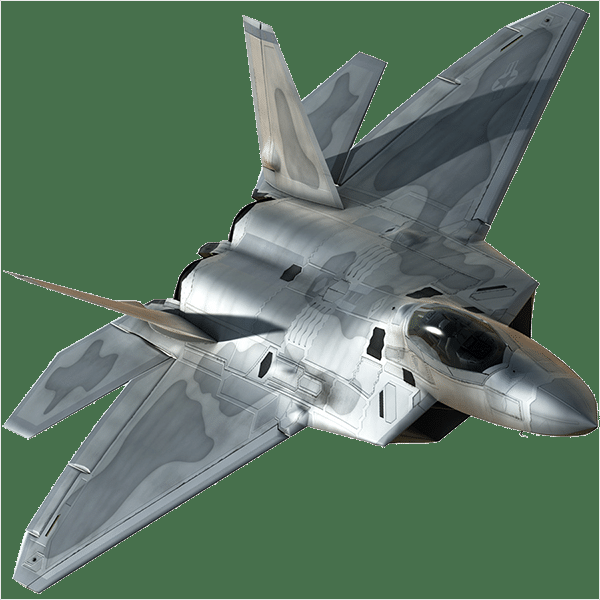

In [80]:
# for f in f14s:
f = fs[fi]
fi += 1
print(f"{fi} / {len(fs)-1}")
print(f.name)
open_image(f)

In [81]:
remove_alphas = [
    'f14/302. kisspng-fighter-aircraft-grumman-f-14-tomcat-airplane-lock-six-5ac6f47fdfbef0.7271332215229881599165.jpg',
    'f22/499. kisspng-lockheed-martin-f-22-raptor-lockheed-martin-f-35-l-f-vector-5ad83d90d81de3.4950145115241209768853.jpg',
    'f22/439. kisspng-lockheed-martin-f-22-raptor-airplane-fighter-aircr-jet-5ac36b0ccef916.0147136315227563648478.jpg',
    #'f22/228. f226191.jpg',
    'f22/313. f22_fighter_jet_r.png',
    
]

In [82]:
for remalpha in remove_alphas:
    try: os.remove(path/'train'/remalpha)
    except FileNotFoundError: pass

In [9]:
for c in data.classes:
    if c in ['mig21']:
        print(c)
        verify_images(path/'train'/c, delete=True, max_workers=1)

mig21


/opt/anaconda3/lib/python3.6/site-packages/PIL/Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [92]:
for c in data.classes:
#     if c in ['f22','mig21']:
    print(c)
    verify_images(path/'train'/c, delete=True, max_workers=1)

f14


f15c


f15e


f16


f22


f35


fa18c


fa18ef


jas39


mig21


mig25


mig29


mig31


rafale


su22


su24


su25


su27


su30


su34


su57
